In [2]:
import numpy as np
from scipy.stats.distributions import gamma, expon, burr, logistic, loggamma, lognorm
from scipy.stats.kde import gaussian_kde
from scipy.stats import kstest
from scipy.optimize import curve_fit
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import warnings
import pandas as pd
from sklearn.mixture import GaussianMixture


style.use("seaborn-white")
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../london_merged.csv", parse_dates=["timestamp"])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [30]:
chosen_vars = ["cnt", "t1", "hum", "wind_speed"]

In [31]:
def kde_estimation(series, bins=50, ax=plt):
    density = gaussian_kde(series)
    x = np.linspace(series.min(), series.max(), 100)
    ax.hist(series, bins=bins, density=True)
    ax.plot(x, density(x), linewidth=3)
    ax.title.set_text(series.name)

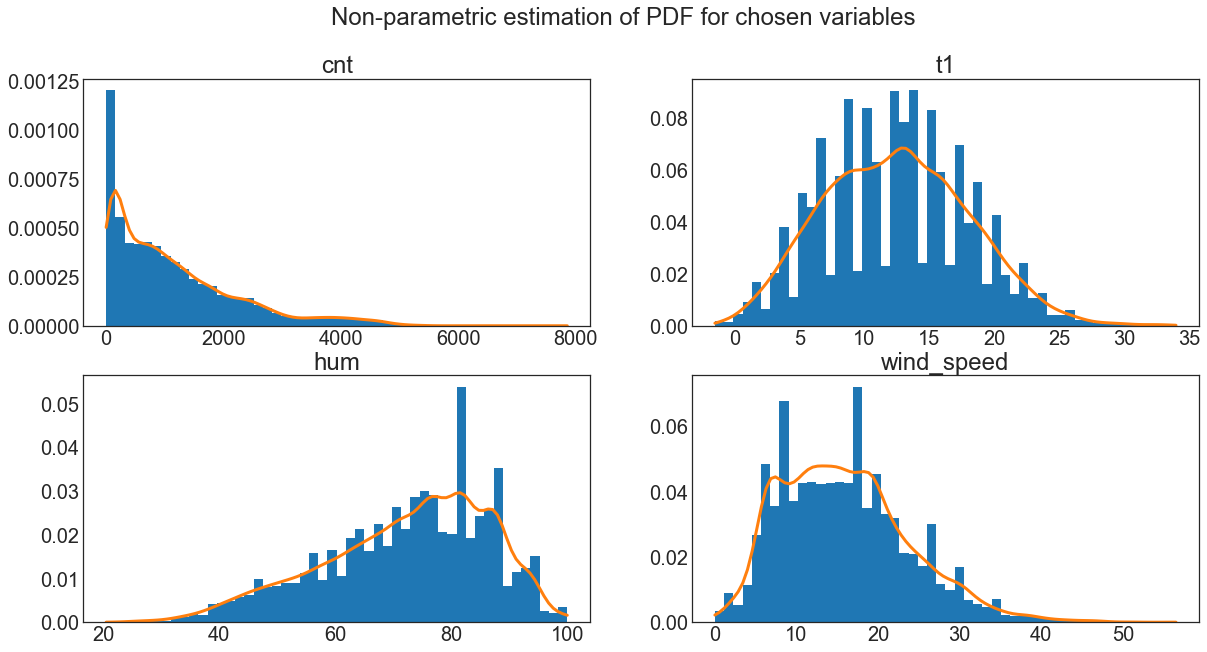

In [32]:
_, axes = plt.subplots(nrows=2, ncols=2)
plt.suptitle('Non-parametric estimation of PDF for chosen variables')
for i, ax in enumerate(axes.flatten()):
    kde_estimation(df[chosen_vars[i]], ax=ax)

In [33]:
# estimation of order statistics
df[chosen_vars].describe()

,cnt,t1,hum,wind_speed
count,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,72.324954,15.913063
std,1085.108068,5.571818,14.313186,7.894570
min,0.000000,-1.500000,20.500000,0.000000
25%,257.000000,8.000000,63.000000,10.000000
50%,844.000000,12.500000,74.500000,15.000000
75%,1671.750000,16.000000,83.000000,20.500000
max,7860.000000,34.000000,100.000000,56.500000


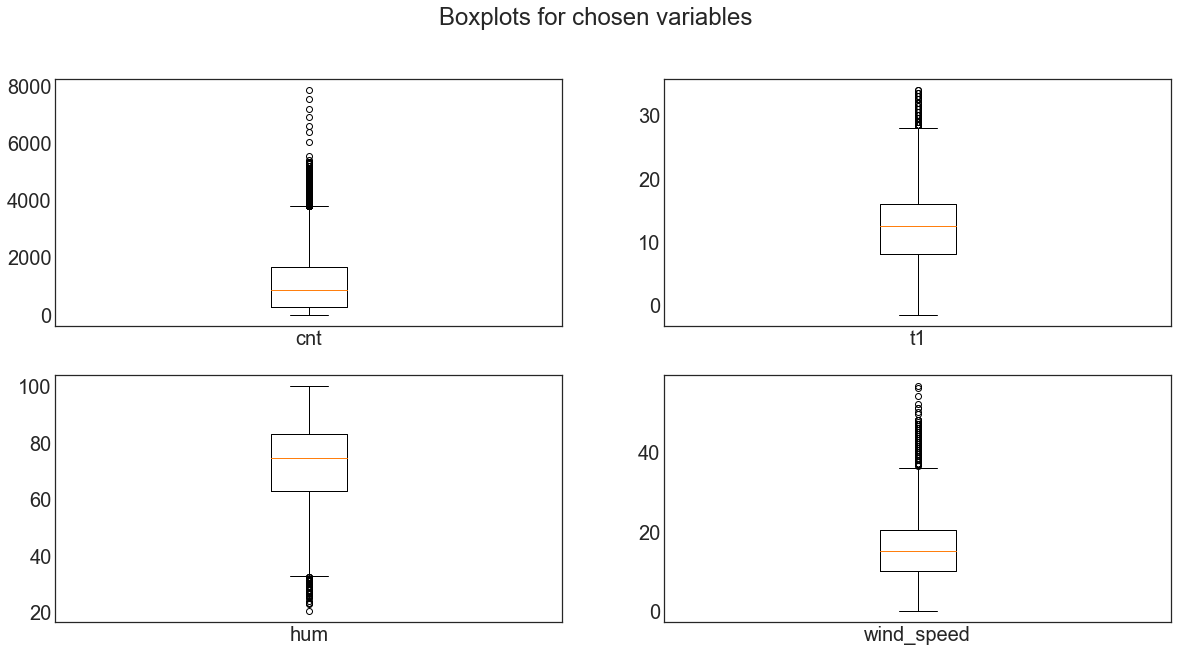

In [34]:
_, axes = plt.subplots(nrows=2, ncols=2)
plt.suptitle('Boxplots for chosen variables')
for i, ax in enumerate(axes.flatten()):
    ax.boxplot(df[chosen_vars[i]], vert=True, labels=[chosen_vars[i]]);

In [35]:
def get_distribution_mle(series, distribution, bins=50, ax=None):
    params = distribution.fit(series)
    y, x = np.histogram(series, density=True, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    estimated_dist = distribution.pdf(x, *params)
    if ax is not None:
        ax.hist(series, density=True, bins=bins)
        ax.plot(x, estimated_dist, linewidth=3)
        ax.title.set_text(series.name)
    return params

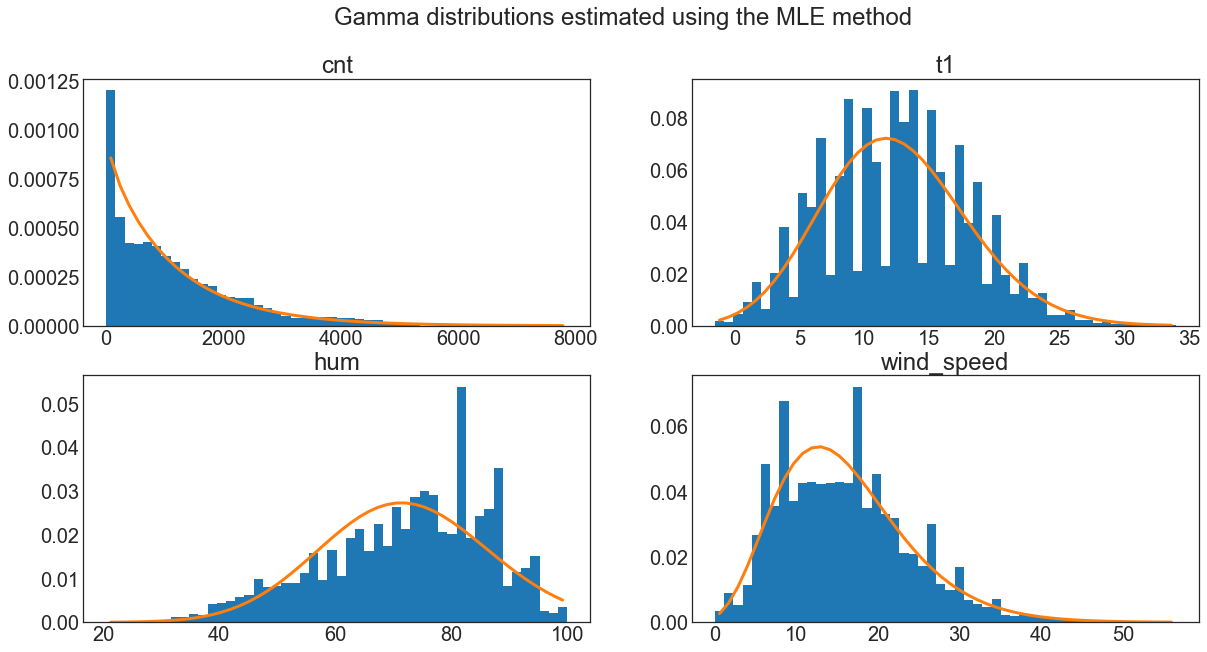

In [37]:
_, axes = plt.subplots(nrows=2, ncols=2)
plt.suptitle('Gamma distributions estimated using the MLE method')
for i, ax in enumerate(axes.flatten()):
    _ = get_distribution_mle(df[chosen_vars[i]], gamma, ax=ax)

In [38]:
def get_distribution_mse(series, distribution, bins=50, ax=None):
    y, x = np.histogram(series, density=True, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    params, _ = curve_fit(distribution.pdf, x, y, p0=[1, 1, 10], maxfev=100000)
    estimated_dist = distribution.pdf(x, *params)
    if ax is not None:
        ax.hist(series, density=True, bins=bins)
        ax.plot(x, estimated_dist, linewidth=3)
        ax.title.set_text(series.name)
    return params

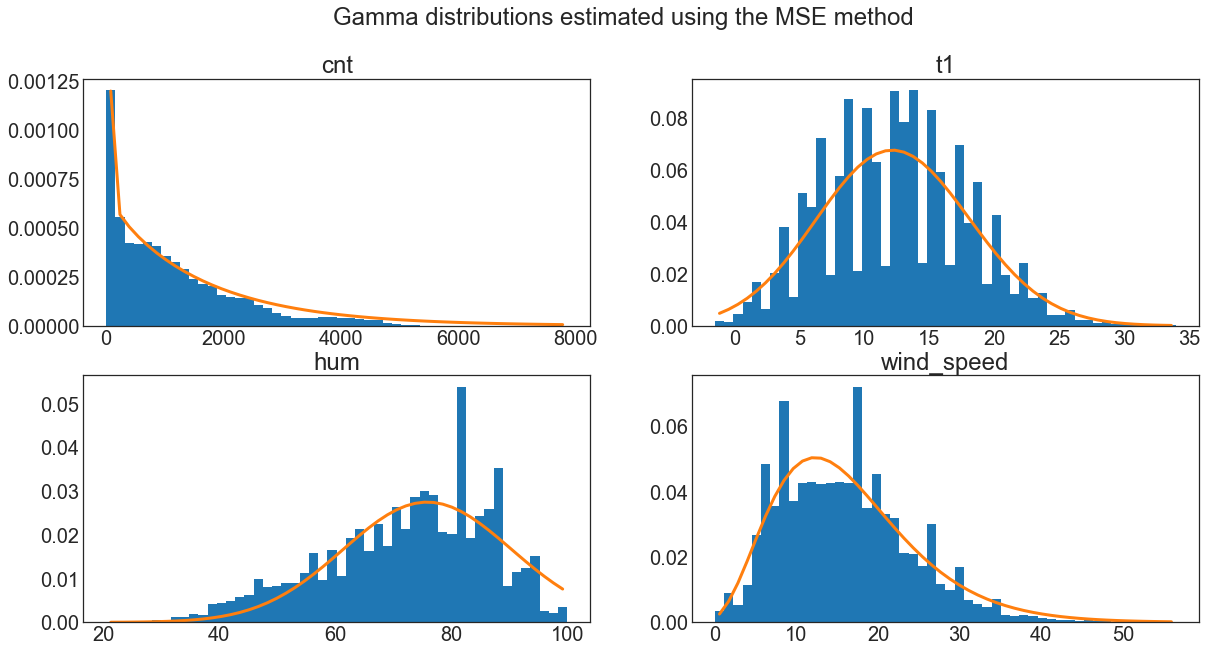

In [39]:
_, axes = plt.subplots(nrows=2, ncols=2)
plt.suptitle('Gamma distributions estimated using the MSE method')
for i, ax in enumerate(axes.flatten()):
    _ = get_distribution_mse(df[chosen_vars[i]], gamma, ax=ax)

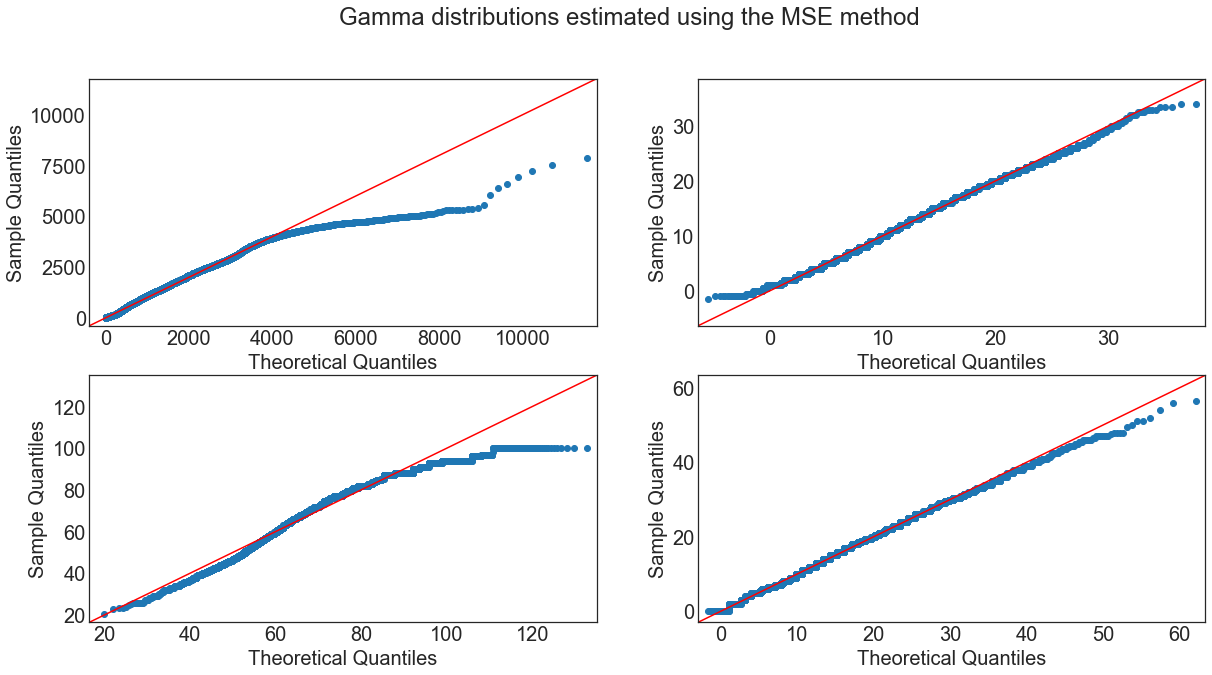

In [40]:
_, axes = plt.subplots(nrows=2, ncols=2)
plt.suptitle('Gamma distributions estimated using the MSE method')
for i, ax in enumerate(axes.flatten()):
    dist_params = get_distribution_mle(df[chosen_vars[i]], gamma)
    qqplot(df[chosen_vars[i]], dist=gamma, distargs=(dist_params[0],), loc=dist_params[1], scale=dist_params[2], line='45', ax=ax)

In [43]:
series = df.wind_speed
dist_params = get_distribution_mle(series, gamma)
kstest(series, 'gamma', args=dist_params,)

KstestResult(statistic=0.040187328800647015, pvalue=7.124346592635539e-25)

In [62]:
gmm = GaussianMixture(n_components=2)
gmm.fit(df[chosen_vars])

GaussianMixture(n_components=2)

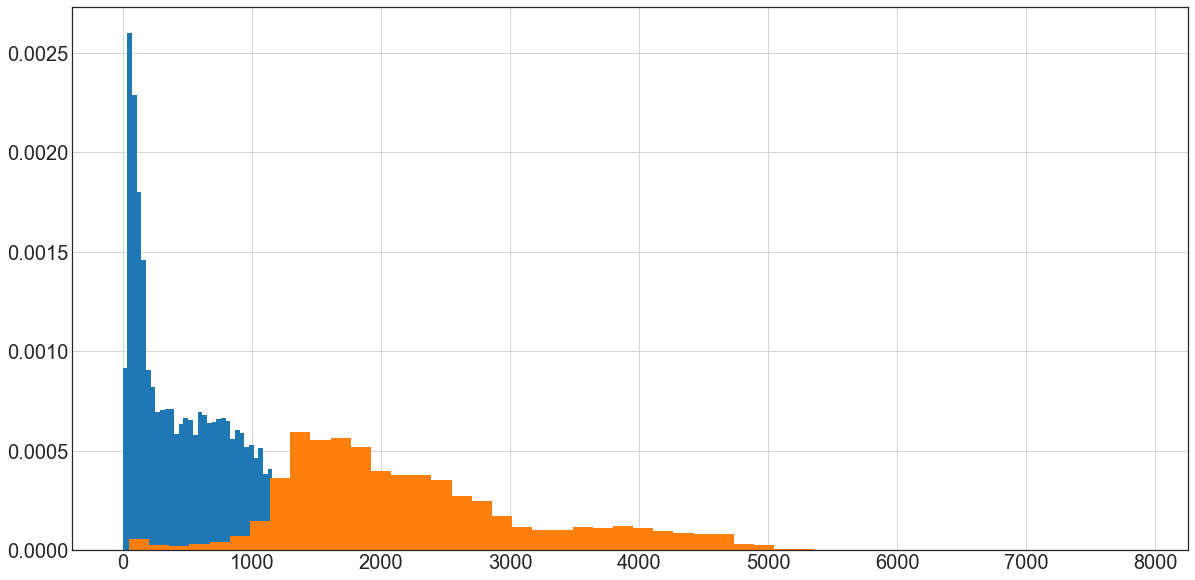

In [64]:
for i in range(2):
    df.cnt[gmm.predict(df[chosen_vars]) == i].hist(bins=50, density=True)